In [1]:
from dotenv import load_dotenv
load_dotenv()

True

### Preparing Data

In [2]:
import os
import pandas as pd
# from groq import Groq

# --- Helper functions to load and combine data (from previous steps) ---

def load_combined_data(topics_filepath="E:/ARooSH/CS/ML/RedCluster/csvs/final_topic_modelling.csv", 
                         comments_filepath="E:/ARooSH/CS/ML/RedCluster/csvs/final_labeled_pain_points.csv", 
                         num_samples=30):
    """
    Loads and combines all necessary data into a single structure.
    """
    try:
        topic_df = pd.read_csv(topics_filepath)
        comments_df = pd.read_csv(comments_filepath)
    except FileNotFoundError as e:
        print(f"Error: Could not find a required file. {e}")
        return []

    # Get comment samples
    cluster_samples = {}
    non_noise_df = comments_df[comments_df['cluster'] != -1]
    for cluster_id, group in non_noise_df.groupby('cluster'):
        sample_size = min(len(group), num_samples)
        cluster_samples[cluster_id] = group.sample(n=sample_size, random_state=42)['comment_text'].tolist()

    # Combine topic details with comment samples
    combined_data = []
    for _, row in topic_df.iterrows():
        cluster_id = row['cluster_id']
        combined_record = {
            "cluster_id": cluster_id,
            "topic_details": row.to_dict(),
            "sample_comments": cluster_samples.get(cluster_id, [])
        }
        combined_data.append(combined_record)
        
    return combined_data



In [3]:
data = load_combined_data()
data[0]

{'cluster_id': 0,
 'topic_details': {'cluster_id': 0,
  'TFIDF Keywords': 'voice, standard voice, standard, voice mode, mode, avm, advanced, advanced voice, like, just',
  'BERTopic Reranked Keywords': 'voice, mode, voice mode, standard voice, advanced voice, avm, different, chatgpt, audio, gpt',
  'flan_t5_topic_label': 'avm vs.',
  'flan_t5_topic_label_rr': 'chatgpt - different voice',
  'oss_topic_label': 'Voice Mode: Standard vs Advanced',
  'oss_topic_label_rr': 'ChatGPT Voice Mode Options',
  'kimik2_topic_label': 'Advanced Voice Mode',
  'kimik2_topic_label_rr': 'Voice Mode Options',
  'llama4_topic_label': 'Advanced Voice Mode is a suitable label, but it can be more concise. \n\nConcise Topic Label: Voice Mode',
  'llama4_topic_label_rr': 'Advanced Voice Mode is a suitable label, but it can be more concise. \n\nConcise Topic Label: Voice Mode',
  'llama4_sum_topics': 'Retain Standard Voice Mode',
  'oss_sum_topic': 'Loss of Preferred Standard Voice Mode'},
 'sample_comments': [

### Pydantic Models and LLM Funcs

In [4]:
from typing import List
from pydantic import BaseModel, Field


# --- 1. Pydantic Models for Structured Output ---

class TopicEvaluation(BaseModel):
    """A model to store the evaluation for a single topic label - NOT TO BE USED FOR Keywords"""
    evidence_set: str = Field(..., description="The evidence set this topic belongs to (e.g., 'A', 'B', or 'C').")
    model_name: str = Field(...,description="Name of the model which produced the topic (eg. GPT-OSS)")
    topic_name: str = Field(..., description="The name of the topic being evaluated i.e its value (e.g., '<the exact topic>').")
    relevance_score: int = Field(..., ge=1, le=10, description="The relevance score from 1 to 10.")
    justification: str = Field(..., description="A brief justification for the score.")

class KeyWordEvaluation(BaseModel):
    """A model to store the evaluation for a single keyword label."""
    model_name: str = Field(...,description="Name of the model which produced the keywords (eg. TFIDF)")
    evidence_set: str = Field(..., description="The evidence set this keyword set belongs to (e.g., 'A', 'B', or 'C').")
    topic_name: str = Field(..., description="Some of the most standout keywords in that set, (eg. TFIDF Keywords: 'gpt-5', .. )")
    relevance_score: int = Field(..., ge=1, le=10, description="The relevance score from 1 to 10.")
    justification: str = Field(..., description="A brief justification for the score. Also mention specific distinct keywords contributing towards the justification")

class ClusterAnalysis(BaseModel):
    """The main model for the complete analysis of a single cluster."""
    relevance_analysis: List[TopicEvaluation] = Field(..., description="A list of evaluations for EACH topic.")
    keyword_analysis: List[KeyWordEvaluation] = Field(..., description="A list of evaluations for each keyword set.")
    best_fit_topic_name: str = Field(..., description="The name of the topic label identified as the best fit. and its value")
    best_fit_justification: str = Field(..., description="Justification for why the identified topic is the best fit.")
    master_topic: str = Field(..., description="The final, synthesized master topic (5-12 words). It should indicate a pain point that is reflected through the comments")
    your_view: str = Field(..., description="Your take based upon the keywords, sample topics and Most Importantly the sample comments as to what the cluster is based on. Can be a short paragraph in markdown, also justifying the master_topic")


In [5]:
import os
import pandas as pd
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage

# --- Updated Function with Pydantic Integration ---

from langchain_core.messages import HumanMessage, SystemMessage

def generate_structured_analysis(structured_llm, cluster_data):
    """
    Generates a structured analysis using a more robust prompt with a system message.
    """
    details = cluster_data['topic_details']
    
    # This evidence block remains the same.
    evidence_text = f"""
    **Evidence Set A: Based on Initial TF-IDF Keywords**
    - Keywords-Model: TFIDF - Raw Keywords (NOT A TOPIC): {details.get('TFIDF Keywords')}
    - Model:Flan-T5 - Topic: {details.get('flan_t5_topic_label')}
    - Model:GPT-OSS - Topic: {details.get('oss_topic_label')}
    - Model:Kimi-k2 - Topic: {details.get('kimik2_topic_label')}
    - Model:Llama4 Maverick - Topic: {details.get("llama4_topic_label")}

    **Evidence Set B: Based on BERTopic Reranked Keywords**
    - Keywords-Model: BERTopic With Maximal Marginal Relevance - Reranked Keywords (NOT A TOPIC): {details.get('BERTopic Reranked Keywords')}
    - Model:Flan-T5 -> Topic(from Reranked): {details.get('flan_t5_topic_label_rr')}
    - Model:GPT-OSS -> Topic(from Reranked): {details.get('oss_topic_label_rr')}
    - Model:Kimi-k2 -> Topic(from Reranked): {details.get('kimik2_topic_label_rr')}
    - Model:Llama4 Maverick -> Topic(from Reranked): {details.get("llama4_topic_label_rr")}

    **Evidence Set C: Based on Summarization of Sample Comments**
    - Model: Llama-4Maverick -> Summary Topic: {details.get('llama4_sum_topics')}
    - Model: GPT-OSS ->  Summary Topic: {details.get('oss_sum_topic')}
    """
    
    sample_comments_formatted = "\n".join([f"  - \"{comment}\"" for comment in cluster_data['sample_comments']])

    # 1. The System Message: Sets the core instruction for the AI.
    system_prompt = """You are a precise data analysis assistant. Your sole purpose is to analyze the provided text and user comments, and then output a single, valid JSON object that strictly conforms to the `ClusterAnalysis` schema. Do not add any conversational text, introductions, or explanations outside of the JSON structure.
    """

    # 2. The Human Message: Provides the data and the direct commands.
    human_prompt = f"""
    Analyze the following evidence package for Cluster {cluster_data['cluster_id']} and generate the `ClusterAnalysis` JSON object.

    **[EVIDENCE]**
    {evidence_text}

    **[SAMPLE COMMENTS]**
    {sample_comments_formatted}

    **[INSTRUCTIONS]**
    1.  Create a JSON object for the `ClusterAnalysis` schema.
    2.  Populate the `relevance_analysis` list by creating a `TopicEvaluation` object for EACH topic label in the evidence.
    3.  Populate the `keyword_analysis` list by creating a `KeyWordEvaluation` object for EACH keyword set in the evidence.
    4.  Do The above step for EACH model and EACH Keyword-set in EACH evidence set, there are some models same in multiple evidence set - Evaluate them SEPERATELY for EACH evidence set.
    5.  Complete the `best_fit_topic_name`, `best_fit_justification`, `master_topic`, and `your_view` fields based on a holistic analysis of all evidence.

    """
    # Combine the messages
    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=human_prompt)
    ]
    
    try:
        # The invoke method remains the same
        return structured_llm.invoke(messages)
    except Exception as e:
        return f"An error occurred: {e}"

In [6]:
try:
        # 1. Initialize the base ChatGroq model
        llm = ChatGroq(temperature=0.1, model_name="meta-llama/llama-4-scout-17b-16e-instruct")
        
        # 2. Bind the Pydantic model to the LLM to create a structured output chain
        structured_llm = llm.with_structured_output(ClusterAnalysis)

except Exception as e:
        print(f"Error initializing ChatGroq or binding the model. {e}")
        # exit()

### Final Evaluation

In [7]:
all_cluster_data = data

if all_cluster_data:
        print("Starting structured analysis with LangChain, Pydantic, and Groq...\n" + "="*60)
        
        target_cluster_data = all_cluster_data[3] # Analyzing Cluster 0
        
        print(f"\n>>> Analyzing Cluster {target_cluster_data['cluster_id']}...")
        
        # 4. Call the function with the new structured LLM
        analysis_result = generate_structured_analysis(structured_llm, target_cluster_data)
        
        # 5. Handle and print the Pydantic object result
        if isinstance(analysis_result, ClusterAnalysis):
            print("\n--- Structured Analysis Received ---")
            
            print("\n**Master Topic:**")
            print(analysis_result.master_topic)

            print("\n**Best Fit Topic:**")
            print(f"  - Name: {analysis_result.best_fit_topic_name}")
            print(f"  - Justification: {analysis_result.best_fit_justification}")

            print(f"  - View: {analysis_result.your_view}")


            print("\n**Detailed Relevance Scores:**")
            for eval_item in analysis_result.relevance_analysis:
                print(f"  - Model: {eval_item.model_name}")
                print(f"  - Topic: {eval_item.topic_name} (Set {eval_item.evidence_set})")
                print(f"    Score: {eval_item.relevance_score}/10")
                print(f"    Justification: {eval_item.justification}")
            
            print("\n**Detailed Keyword Relevance Scores:**")
            for eval_item in analysis_result.keyword_analysis:
                print(f"  - Topic: {eval_item.topic_name} (Set {eval_item.evidence_set})")
                print(f"    Score: {eval_item.relevance_score}/10")
                print(f"    Justification: {eval_item.justification}")
            
        
            
        else:
            print("\n--- An error occurred ---")
            print(analysis_result)

        print("="*60)
else:
        print("Could not load data.")

Starting structured analysis with LangChain, Pydantic, and Groq...

>>> Analyzing Cluster 3...

--- Structured Analysis Received ---

**Master Topic:**
Preserving Access to OpenAI GPT-4o Model

**Best Fit Topic:**
  - Name: OpenAI GPT-4o Model
  - Justification: The topic 'OpenAI GPT-4o Model' is identified as the best fit due to its high relevance score across multiple evidence sets and models, directly relating to the central theme of preserving access to GPT-4o.
  - View: The cluster revolves around the theme of users expressing their dissatisfaction with the removal of the OpenAI GPT-4o model and requesting its reinstatement. Users highlight the unique features and benefits of GPT-4o, such as its tone, reasoning style, and consistency, which were crucial for their work, creativity, and well-being. The sudden removal of GPT-4o without offering it as a legacy option has caused significant disruption, especially for those who relied on it for therapeutic support, writing, and other cr

In [42]:
analysis_result

ClusterAnalysis(relevance_analysis=[TopicEvaluation(evidence_set='A', model_name='Flan-T5', topic_name='avm vs.', relevance_score=6, justification="The topic 'avm vs.' is somewhat relevant as it touches on the comparison between different voice modes, but it lacks specificity and clarity."), TopicEvaluation(evidence_set='A', model_name='GPT-OSS', topic_name='Voice Mode: Standard vs Advanced', relevance_score=9, justification="This topic is highly relevant as it directly compares standard and advanced voice modes, aligning with the user comments' focus on this issue."), TopicEvaluation(evidence_set='A', model_name='Kimi-k2', topic_name='Advanced Voice Mode', relevance_score=7, justification="The topic 'Advanced Voice Mode' is relevant but doesn't capture the full scope of user concerns, which also include standard voice mode."), TopicEvaluation(evidence_set='B', model_name='Flan-T5', topic_name='chatgpt - different voice', relevance_score=5, justification='This topic is somewhat relevan

In [97]:
# Assuming 'analysis_result' is your Pydantic object from the LLM
def to_dict(analysis_result):
    if isinstance(analysis_result, ClusterAnalysis):
        
        # This is the line that converts the Pydantic object to a dictionary
        analysis_dict = analysis_result.model_dump()
        
        # Now you can work with it like a regular dictionary
        print("--- Accessing data from the converted dictionary ---")
        print(f"Master Topic: {analysis_dict['master_topic']}")
        
        # You can also easily convert it to a JSON string from the dictionary
        import json
        json_output = json.dumps(analysis_dict, indent=4)
        # print(json_output)
        return analysis_dict

In [ ]:
all_cluster_analysis_results = []

In [133]:
all_cluster_analysis_results.append((9, analysis_result))

In [134]:
all_cluster_analysis_results

[(0,
  ClusterAnalysis(relevance_analysis=[TopicEvaluation(evidence_set='A', model_name='Flan-T5', topic_name='avm vs.', relevance_score=6, justification="The topic 'avm vs.' from Flan-T5 in Evidence Set A seems to be a starting point but lacks specificity and clarity regarding the voice mode comparison."), TopicEvaluation(evidence_set='A', model_name='GPT-OSS', topic_name='Voice Mode: Standard vs Advanced', relevance_score=9, justification="The topic 'Voice Mode: Standard vs Advanced' from GPT-OSS in Evidence Set A directly addresses the comparison between standard and advanced voice modes, making it highly relevant."), TopicEvaluation(evidence_set='A', model_name='Kimi-k2', topic_name='Advanced Voice Mode', relevance_score=8, justification="The topic 'Advanced Voice Mode' from Kimi-k2 in Evidence Set A focuses on a specific aspect of voice mode but doesn't explicitly compare standard and advanced modes."), TopicEvaluation(evidence_set='A', model_name='Llama4 Maverick', topic_name='Ad

In [135]:
save_results = all_cluster_analysis_results

In [136]:
save_results

[(0,
  ClusterAnalysis(relevance_analysis=[TopicEvaluation(evidence_set='A', model_name='Flan-T5', topic_name='avm vs.', relevance_score=6, justification="The topic 'avm vs.' from Flan-T5 in Evidence Set A seems to be a starting point but lacks specificity and clarity regarding the voice mode comparison."), TopicEvaluation(evidence_set='A', model_name='GPT-OSS', topic_name='Voice Mode: Standard vs Advanced', relevance_score=9, justification="The topic 'Voice Mode: Standard vs Advanced' from GPT-OSS in Evidence Set A directly addresses the comparison between standard and advanced voice modes, making it highly relevant."), TopicEvaluation(evidence_set='A', model_name='Kimi-k2', topic_name='Advanced Voice Mode', relevance_score=8, justification="The topic 'Advanced Voice Mode' from Kimi-k2 in Evidence Set A focuses on a specific aspect of voice mode but doesn't explicitly compare standard and advanced modes."), TopicEvaluation(evidence_set='A', model_name='Llama4 Maverick', topic_name='Ad

In [128]:
all_cluster_analysis_results[8] = (8, all_cluster_analysis_results[8][1])

In [ ]:
to_dict(analysis_result)

{'relevance_analysis': [{'evidence_set': 'A',
   'model_name': 'Flan-T5',
   'topic_name': 'avm vs.',
   'relevance_score': 6,
   'justification': "The topic 'avm vs.' is somewhat relevant as it touches on the comparison between different voice modes, but it lacks specificity and clarity."},
  {'evidence_set': 'A',
   'model_name': 'GPT-OSS',
   'topic_name': 'Voice Mode: Standard vs Advanced',
   'relevance_score': 9,
   'justification': "This topic is highly relevant as it directly compares standard and advanced voice modes, aligning with the user comments' focus on this issue."},
  {'evidence_set': 'A',
   'model_name': 'Kimi-k2',
   'topic_name': 'Advanced Voice Mode',
   'relevance_score': 7,
   'justification': "The topic 'Advanced Voice Mode' is relevant but doesn't capture the full scope of user concerns, which also include standard voice mode."},
  {'evidence_set': 'B',
   'model_name': 'Flan-T5',
   'topic_name': 'chatgpt - different voice',
   'relevance_score': 5,
   'justi

### Creating Relational DataFrames

In [45]:
def create_relational_dataframes(analysis_dict, cluster_id):
    """
    Converts the nested analysis dictionary into three separate, normalized DataFrames.
    """
    # 1. Create the 'clusters' DataFrame (one row for this cluster)
    clusters_df = pd.DataFrame([{
        'cluster_id': cluster_id,
        'master_topic': analysis_dict['master_topic'],
        'best_fit_topic': analysis_dict['best_fit_topic_name'],
        'best_fit_justification': analysis_dict['best_fit_justification'],
        'analyst_view': analysis_dict['your_view']
    }])
    
    # 2. Create the 'topic_evaluations' DataFrame
    topic_evals_df = pd.DataFrame(analysis_dict['relevance_analysis'])
    topic_evals_df['cluster_id'] = cluster_id # Add the foreign key
    
    # 3. Create the 'keyword_evaluations' DataFrame
    keyword_evals_df = pd.DataFrame(analysis_dict['keyword_analysis'])
    keyword_evals_df['cluster_id'] = cluster_id # Add the foreign key
    
    return clusters_df, topic_evals_df, keyword_evals_df


In [ ]:
c,d,k = create_relational_dataframes(to_dict(analysis_result=analysis_result), cluster_id=0)

In [47]:
c

,cluster_id,master_topic,best_fit_topic,best_fit_justification,analyst_view
0,0,Preservation of Standard Voice Mode in GPT-5,Retain Standard Voice Mode,The topic 'Retain Standard Voice Mode' is the ...,The cluster analysis reveals a strong user pre...


In [48]:
d

,evidence_set,model_name,topic_name,relevance_score,justification,cluster_id
0,A,Flan-T5,avm vs.,6,The topic 'avm vs.' is somewhat relevant as it...,0
1,A,GPT-OSS,Voice Mode: Standard vs Advanced,9,This topic is highly relevant as it directly c...,0
2,A,Kimi-k2,Advanced Voice Mode,7,The topic 'Advanced Voice Mode' is relevant bu...,0
3,B,Flan-T5,chatgpt - different voice,5,This topic is somewhat relevant but lacks clar...,0
4,B,GPT-OSS,ChatGPT Voice Mode Options,8,This topic is relevant as it addresses voice m...,0
5,C,Llama-4Maverick,Retain Standard Voice Mode,10,This topic is highly relevant as it directly a...,0
6,C,GPT-OSS,Loss of Preferred Standard Voice Mode,10,This topic is highly relevant as it captures t...,0


In [49]:
k

,model_name,evidence_set,topic_name,relevance_score,justification,cluster_id
0,TFIDF,A,"voice, standard voice, standard, voice mode, m...",8,The TFIDF keywords are relevant as they highli...,0
1,BERTopic With Maximal Marginal Relevance,B,"voice, mode, voice mode, standard voice, advan...",9,The BERTopic reranked keywords are highly rele...,0


In [137]:
import pandas as pd

def process_all_clusters_to_relational(all_analysis_results):
    """
    Processes a list of cluster analysis dictionaries into three final, normalized DataFrames.

    Args:
        all_analysis_results (list): A list of tuples, where each tuple is
                                     (cluster_id, analysis_dictionary).

    Returns:
        tuple: A tuple containing the three final pandas DataFrames:
               (final_clusters_df, final_topic_evals_df, final_keyword_evals_df).
    """
    # Initialize empty lists to hold the small DataFrames from each cluster
    clusters_list = []
    topic_evals_list = []
    keyword_evals_list = []

    # Loop through all your results
    for cluster_id, analysis_dict in all_analysis_results:

        analysis_dict = to_dict(analysis_dict)
        # Process one cluster's dictionary using our existing helper function
        c_df, t_df, k_df = create_relational_dataframes(analysis_dict, cluster_id)
        
        # Append the resulting DataFrames to our lists
        clusters_list.append(c_df)
        topic_evals_list.append(t_df)
        keyword_evals_list.append(k_df)

    # Concatenate the lists of DataFrames into three final master DataFrames
    final_clusters_df = pd.concat(clusters_list, ignore_index=True)
    final_topic_evals_df = pd.concat(topic_evals_list, ignore_index=True)
    final_keyword_evals_df = pd.concat(keyword_evals_list, ignore_index=True)
    
    return final_clusters_df, final_topic_evals_df, final_keyword_evals_df

In [139]:
clusters, topic, evals = process_all_clusters_to_relational(save_results)

--- Accessing data from the converted dictionary ---
Master Topic: Users are concerned about the removal of Standard Voice Mode and its replacement with Advanced Voice Mode, seeking to retain the former for its natural warmth and functionality.
--- Accessing data from the converted dictionary ---
Master Topic: GPT-5 Underperforms
--- Accessing data from the converted dictionary ---
Master Topic: Users are frustrated with the removal of the GPT-4o model and request its return or the option to choose between models.
--- Accessing data from the converted dictionary ---
Master Topic: The removal of OpenAI's GPT-4o model and its impact on users
--- Accessing data from the converted dictionary ---
Master Topic: Moderation and Censorship Concerns
--- Accessing data from the converted dictionary ---
Master Topic: ChatGPT Context Window Limitation Frustration
--- Accessing data from the converted dictionary ---
Master Topic: Users are upset about the discontinuation of GPT-4o and legacy models,

### Analysis of Evaluation

In [68]:
to_dict(analysis_result=all_cluster_analysis_results[0][1])

--- Accessing data from the converted dictionary ---
Master Topic: Users want to retain the standard voice mode in GPT-5


{'relevance_analysis': [{'evidence_set': 'A',
   'model_name': 'TFIDF',
   'topic_name': 'Voice Mode',
   'relevance_score': 8,
   'justification': "The topic 'Voice Mode' is highly relevant as it encompasses the main concern of users regarding the changes to voice modes in GPT-5, including the discontinuation of standard voice mode and the introduction of advanced voice mode."},
  {'evidence_set': 'B',
   'model_name': 'BERTopic',
   'topic_name': 'Voice Mode Options',
   'relevance_score': 9,
   'justification': "The topic 'Voice Mode Options' is highly relevant as it reflects the user's need for choices in voice modes, with a focus on the distinction between standard and advanced voice modes."},
  {'evidence_set': 'C',
   'model_name': 'Llama-4Maverick',
   'topic_name': 'Retain Standard Voice Mode',
   'relevance_score': 9,
   'justification': "The topic 'Retain Standard Voice Mode' is highly relevant as it directly addresses the primary concern of many users, which is to retain th

In [143]:
topic.head()

,evidence_set,model_name,topic_name,relevance_score,justification,cluster_id
0,A,Flan-T5,avm vs.,6,The topic 'avm vs.' from Flan-T5 in Evidence S...,0
1,A,GPT-OSS,Voice Mode: Standard vs Advanced,9,The topic 'Voice Mode: Standard vs Advanced' f...,0
2,A,Kimi-k2,Advanced Voice Mode,8,The topic 'Advanced Voice Mode' from Kimi-k2 i...,0
3,A,Llama4 Maverick,"Advanced Voice Mode is a suitable label, but i...",7,The topic from Llama4 Maverick in Evidence Set...,0
4,B,Flan-T5,chatgpt - different voice,5,The topic 'chatgpt - different voice' from Fla...,0


In [144]:
clusters.head()

,cluster_id,master_topic,best_fit_topic,best_fit_justification,analyst_view
0,0,Users are concerned about the removal of Stand...,Voice Mode,The topic 'Voice Mode' best captures the essen...,The cluster revolves around user dissatisfacti...
1,1,GPT-5 Underperforms,GPT-5 Performance Issues,The best fit topic name is 'GPT-5 Performance ...,The cluster analysis indicates a significant c...
2,2,Users are frustrated with the removal of the G...,GPT-4o Model Removal and Restoration,The topic best fits the evidence as it directl...,The cluster revolves around users' dissatisfac...
3,3,The removal of OpenAI's GPT-4o model and its i...,OpenAI GPT-4o Model,The topic 'OpenAI GPT-4o Model' is the best fi...,The cluster revolves around the removal of Ope...
4,4,Moderation and Censorship Concerns,Moderation Issues,The topic 'Moderation Issues' best captures th...,"Based on the evidence and sample comments, the..."


In [5]:
evals.head()

,Unnamed: 0,model_name,evidence_set,topic_name,relevance_score,justification,cluster_id
0,0,TFIDF,A,"TFIDF Keywords: 'gpt-5', ..",4,The TFIDF keywords in Evidence Set A provide a...,0
1,1,TFIDF,A,"Raw Keywords (NOT A TOPIC): voice, standard vo...",5,The raw keywords from TFIDF in Evidence Set A ...,0
2,2,BERTopic With Maximal Marginal Relevance,B,"Reranked Keywords (NOT A TOPIC): voice, mode, ...",6,The reranked keywords from BERTopic in Evidenc...,0
3,3,TFIDF,A,"TFIDF Keywords: gpt-5, image, model, gpt5, ins...",8,"These keywords directly relate to GPT-5, its p...",1
4,4,BERTopic With Maximal Marginal Relevance,B,"BERTopic Keywords: image gen, generation, sora...",7,These keywords relate to image and video gener...,1


In [1]:
import pandas as pd
evals = pd.read_csv("E:/ARooSH/CS/ML/RedCluster/csvs/evals.csv")

In [6]:
condition_to_drop = evals['model_name'].str.startswith("Llama")
evals = evals[~condition_to_drop]

In [ ]:
# evals.to_csv("E:/ARooSH/CS/ML/RedCluster/csvs/evals.csv")

In [45]:
topics = pd.read_csv("E:/ARooSH/CS/ML/RedCluster/csvs/final_llm_topics.csv")
topics

,evidence_set,model_name,topic_name,relevance_score,justification,cluster_id
0,A,Flan-T5,avm vs.,6,The topic 'avm vs.' from Flan-T5 in Evidence S...,0
1,A,GPT-OSS,Voice Mode: Standard vs Advanced,9,The topic 'Voice Mode: Standard vs Advanced' f...,0
2,A,Kimi-k2,Advanced Voice Mode,8,The topic 'Advanced Voice Mode' from Kimi-k2 i...,0
3,A,Llama4 Maverick,"Advanced Voice Mode is a suitable label, but i...",7,The topic from Llama4 Maverick in Evidence Set...,0
4,B,Flan-T5,chatgpt - different voice,5,The topic 'chatgpt - different voice' from Fla...,0
...,...,...,...,...,...,...
106,B,GPT-OSS,OpenAI AI Safety & Trust,9,The topic 'OpenAI AI Safety & Trust' is highly...,9
107,B,Kimi-k2,OpenAI User Trust,8,The topic 'OpenAI User Trust' is highly releva...,9
108,B,Llama4 Maverick,AI Safety Concerns for Users,8,The topic 'AI Safety Concerns for Users' is hi...,9
109,C,Llama-4Maverick,AI Safety and Ethics,8,The topic 'AI Safety and Ethics' is highly rel...,9


In [46]:
mean_scores_by_es = topics.groupby(by=['model_name', 'evidence_set'])['relevance_score'].mean()

In [47]:
mean_scores_es = mean_scores_by_es.reset_index()

In [48]:
mean_scores_by_es = pd.DataFrame(mean_scores_by_es)

mean_scores_by_es = mean_scores_by_es.reset_index()

In [49]:
mean_scores_by_es = mean_scores_by_es[~mean_scores_by_es['model_name'].isin(['BERTopic With Maximal Marginal Relevance','TFIDF'])]
mean_scores_by_es

,model_name,evidence_set,relevance_score
1,Flan-T5,A,7.2
2,Flan-T5,B,5.9
3,GPT-OSS,A,9.0
4,GPT-OSS,B,8.5
5,GPT-OSS,C,8.8
6,Kimi-k2,A,7.7
7,Kimi-k2,B,7.6
8,Llama-4Maverick,C,8.5
9,Llama4 Maverick,A,8.1
10,Llama4 Maverick,B,8.0


In [50]:
mean_scores_by_es

,model_name,evidence_set,relevance_score
1,Flan-T5,A,7.2
2,Flan-T5,B,5.9
3,GPT-OSS,A,9.0
4,GPT-OSS,B,8.5
5,GPT-OSS,C,8.8
6,Kimi-k2,A,7.7
7,Kimi-k2,B,7.6
8,Llama-4Maverick,C,8.5
9,Llama4 Maverick,A,8.1
10,Llama4 Maverick,B,8.0


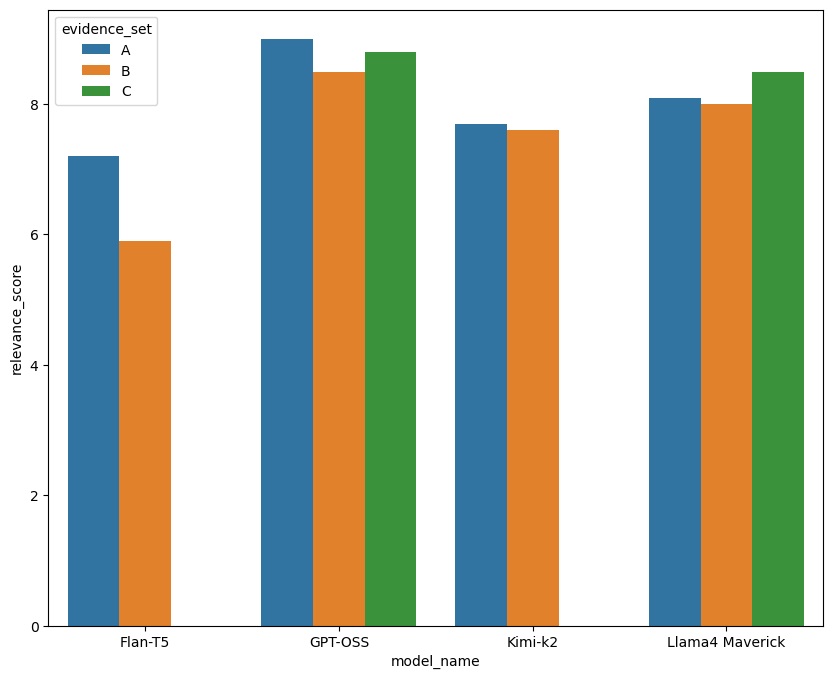

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

mean_scores_by_es.loc[12,'model_name'] = 'Llama4 Maverick'

plt.figure(figsize=(10,8))
sns.barplot(x=mean_scores_by_es['model_name'], y=mean_scores_by_es['relevance_score'], hue=mean_scores_by_es['evidence_set'])
plt.show()

In [18]:
cluster_avg = pd.DataFrame(topics.groupby(by=['cluster_id', 'evidence_set'])['relevance_score'].mean()).reset_index()

cluster_avg.head()

,cluster_id,evidence_set,relevance_score
0,0,A,7.50
1,0,B,6.50
2,0,C,8.50
3,1,A,7.75
4,1,B,7.00


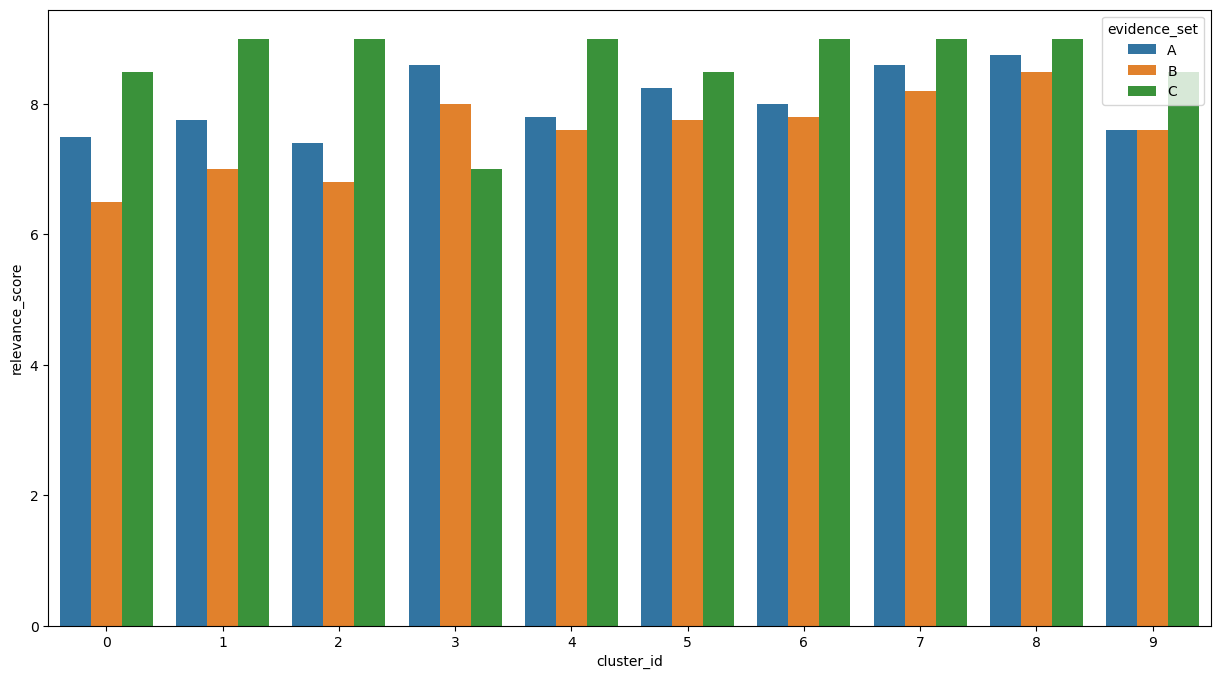

In [17]:
plt.figure(figsize=(15,8))
sns.barplot(x=cluster_avg['cluster_id'], y=cluster_avg['relevance_score'], hue=cluster_avg['evidence_set'])
plt.show()

In [7]:
! pip install tabulate

In [15]:
print(mean_scores_df.to_markdown(index=False))

| model_name                               | evidence_set   |   relevance_score |
|:-----------------------------------------|:---------------|------------------:|
| BERTopic With Maximal Marginal Relevance | B              |           8.2     |
| Flan-T5                                  | A              |           7.2     |
| Flan-T5                                  | B              |           5.9     |
| GPT-OSS                                  | A              |           9       |
| GPT-OSS                                  | B              |           8.5     |
| GPT-OSS                                  | C              |           8.8     |
| Kimi-k2                                  | A              |           7.7     |
| Kimi-k2                                  | B              |           7.6     |
| Llama-4Maverick                          | C              |           8.5     |
| Llama4 Maverick                          | A              |           8.1     |
| Llama4 Maveric

Mean Relevance score of each model on each evidence set across all clusters.

GPT OSS clearly the best performer, along with LLama Maveric, -> Also the Summary topics (Set C ) perform much better than any keywords on aveg (GPT-OSS on set A being an exception)
and then, we can clearly see set A performing better than set B, which means original TFIDF Keywords (Before Reranking ) was perhaps the better set. 

### Final Clusters

In [51]:
topics['model_name'] = topics['model_name'].replace({
    'Llama-4Maverick':'Llama4 Maverick'
})

In [52]:
topics['model_name'].unique()

array(['Flan-T5', 'GPT-OSS', 'Kimi-k2', 'Llama4 Maverick', 'TFIDF',
       'BERTopic With Maximal Marginal Relevance'], dtype=object)

In [53]:
pivot = topics.pivot_table(index=['cluster_id','evidence_set'], columns='model_name', values='topic_name',aggfunc=', '.join )

In [54]:
pivot.drop(columns=['BERTopic With Maximal Marginal Relevance','TFIDF'], inplace=True)

In [55]:
pivot

model_name                                              Flan-T5  \
cluster_id evidence_set                                           
0          A                                            avm vs.   
           B                          chatgpt - different voice   
           C                                                NaN   
1          A                              image result for gpt5   
           B                                              gpt4o   
           C                                                NaN   
2          A                                mobile phones gpt o   
           B             choose model from the dropdown menu to   
           C                                                NaN   
3          A                                        openai gpt4   
           B                                        openai -lrb   
           C                                                NaN   
4          A                     don t you just love how people   
           B                                      sam jones ama   
           C                                                NaN   
5          A                                       chatgpt32 kb   
           B                                 chatgpt uses32k of   
           C                                                NaN   
6          A                           don just want to chat gp   
           B                                  chatgpt is a free   
           C                                                NaN   
7          A                                   gpt4o users just   
           B                         choosing the right gpt for   
           C                                                NaN   
8          A                           gpt filtering for people   
           B                         chatgpt flagged as harmful   
           C                                                NaN   
9          A                    don't worry about the safety of   
           B                                     openai samsung   
           C                                                NaN   

model_name                                                     GPT-OSS  \
cluster_id evidence_set                                                  
0          A                          Voice Mode: Standard vs Advanced   
           B                                ChatGPT Voice Mode Options   
           C                     Loss of Preferred Standard Voice Mode   
1          A                             GPT-5 Image Model Performance   
           B                           Sora Image and Video Generation   
           C               Unmet expectations and degraded performance   
2          A                                        Using GPT-4o Model   
           B                            Model Management and Selection   
           C                               Restore GPT-4o model option   
3          A                                       OpenAI GPT‑4o Model   
           B                      OpenAI Model Transparency Benchmarks   
           C                  Removed models break workflow continuity   
4          A                                           AMA Q&A Session   
           B                          AMA Answers and Profile Comments   
           C                 Ignored feedback and perceived censorship   
5          A                                 ChatGPT32k Context Window   
           B                                   ChatGPT Plus32k Context   
           C                               Limited context window size   
6          A                             People Want GPT‑4o Chat Model   
           B                         ChatGPT as Professional Companion   
           C                              Missing legacy model options   
7          A                                     GPT‑4o Emotional Tone   
           B                     Choosing GPT‑4o for Emotional Support   
     

In [59]:
clusters = pd.read_csv("E:/ARooSH/CS/ML/RedCluster/csvs/final_llm_clusters.csv")
clusters

,cluster_id,master_topic,best_fit_topic,best_fit_justification,analyst_view
0,0,Users are concerned about the removal of Stand...,Voice Mode,The topic 'Voice Mode' best captures the essen...,The cluster revolves around user dissatisfacti...
1,1,GPT-5 Underperforms,GPT-5 Performance Issues,The best fit topic name is 'GPT-5 Performance ...,The cluster analysis indicates a significant c...
2,2,Users are frustrated with the removal of the G...,GPT-4o Model Removal and Restoration,The topic best fits the evidence as it directl...,The cluster revolves around users' dissatisfac...
3,3,The removal of OpenAI's GPT-4o model and its i...,OpenAI GPT-4o Model,The topic 'OpenAI GPT-4o Model' is the best fi...,The cluster revolves around the removal of Ope...
4,4,Moderation and Censorship Concerns,Moderation Issues,The topic 'Moderation Issues' best captures th...,"Based on the evidence and sample comments, the..."
5,5,ChatGPT Context Window Limitation Frustration,Context Window Limitation,The best fit topic is 'Context Window Limitati...,The cluster is based on user frustration with ...
6,6,Users are upset about the discontinuation of G...,Users Want GPT-4o Back,The best-fit topic name is justified by the pr...,The cluster revolves around users expressing d...
7,7,Users are concerned about the removal of GPT-4...,GPT-4o Emotional Tone,The topic 'GPT-4o Emotional Tone' best fits th...,The cluster analysis reveals that users highly...
8,8,Overly Strict Content Censorship in ChatGPT,Harmful Sexual Content Filtering,This topic best fits the evidence as it direct...,The cluster is based on concerns about overly ...
9,9,"Trust, Safety, and Ethics in AI Systems",AI Safety and User Trust,The topic 'AI Safety and User Trust' best fits...,The cluster revolves around concerns and discu...


In [83]:
new_cols = []
for col in pivot.columns:
    n =""
    for c in col.split('_'):
        n = n + c

    print(n)
    new_cols.append(n)

new_cols
pivot.columns= new_cols
pivot


Flan-T5
GPT-OSS
Kimi-k2
Llama4 Maverick


Flan-T5  \
cluster_id evidence_set                                           
0          A                                            avm vs.   
           B                          chatgpt - different voice   
           C                                                NaN   
1          A                              image result for gpt5   
           B                                              gpt4o   
           C                                                NaN   
2          A                                mobile phones gpt o   
           B             choose model from the dropdown menu to   
           C                                                NaN   
3          A                                        openai gpt4   
           B                                        openai -lrb   
           C                                                NaN   
4          A                     don t you just love how people   
           B                                      sam jones ama   
           C                                                NaN   
5          A                                       chatgpt32 kb   
           B                                 chatgpt uses32k of   
           C                                                NaN   
6          A                           don just want to chat gp   
           B                                  chatgpt is a free   
           C                                                NaN   
7          A                                   gpt4o users just   
           B                         choosing the right gpt for   
           C                                                NaN   
8          A                           gpt filtering for people   
           B                         chatgpt flagged as harmful   
           C                                                NaN   
9          A                    don't worry about the safety of   
           B                                     openai samsung   
           C                                                NaN   

                                                               GPT-OSS  \
cluster_id evidence_set                                                  
0          A                          Voice Mode: Standard vs Advanced   
           B                                ChatGPT Voice Mode Options   
           C                     Loss of Preferred Standard Voice Mode   
1          A                             GPT-5 Image Model Performance   
           B                           Sora Image and Video Generation   
           C               Unmet expectations and degraded performance   
2          A                                        Using GPT-4o Model   
           B                            Model Management and Selection   
           C                               Restore GPT-4o model option   
3          A                                       OpenAI GPT‑4o Model   
           B                      OpenAI Model Transparency Benchmarks   
           C                  Removed models break workflow continuity   
4          A                                           AMA Q&A Session   
           B                          AMA Answers and Profile Comments   
           C                 Ignored feedback and perceived censorship   
5          A                                 ChatGPT32k Context Window   
           B                                   ChatGPT Plus32k Context   
           C                               Limited context window size   
6          A                             People Want GPT‑4o Chat Model   
           B                         ChatGPT as Professional Companion   
           C                              Missing legacy model options   
7          A                                     GPT‑4o Emotional Tone   
           B                     Choosing GPT‑4o for Emotional Support   
           C                       Forced Model Switch Remove

In [89]:
pivot.reset_index().columns

Index(['cluster_id', 'evidence_set', 'Flan-T5', 'GPT-OSS', 'Kimi-k2',
       'Llama4 Maverick'],
      dtype='object')

In [90]:
topic_analytics = pd.merge(pivot.reset_index(), clusters[['master_topic','analyst_view','cluster_id']], on='cluster_id')

In [91]:
topic_analytics

,cluster_id,evidence_set,Flan-T5,GPT-OSS,Kimi-k2,Llama4 Maverick,master_topic,analyst_view
0,0,A,avm vs.,Voice Mode: Standard vs Advanced,Advanced Voice Mode,"Advanced Voice Mode is a suitable label, but i...",Users are concerned about the removal of Stand...,The cluster revolves around user dissatisfacti...
1,0,B,chatgpt - different voice,ChatGPT Voice Mode Options,Voice Mode Options,"Advanced Voice Mode is a suitable label, but i...",Users are concerned about the removal of Stand...,The cluster revolves around user dissatisfacti...
2,0,C,NaN,Loss of Preferred Standard Voice Mode,NaN,Retain Standard Voice Mode,Users are concerned about the removal of Stand...,The cluster revolves around user dissatisfacti...
3,1,A,image result for gpt5,GPT-5 Image Model Performance,GPT-4o Output Drop,GPT Model Image Output Quality,GPT-5 Underperforms,The cluster analysis indicates a significant c...
4,1,B,gpt4o,Sora Image and Video Generation,AI Image & Video Creation,GPT Model Image Output Quality,GPT-5 Underperforms,The cluster analysis indicates a significant c...
5,1,C,NaN,Unmet expectations and degraded performance,NaN,Poor Performance in GPT-5,GPT-5 Underperforms,The cluster analysis indicates a significant c...
6,2,A,mobile phones gpt o,Using GPT-4o Model,GPT Model Comparison,GPT Model Comparison,Users are frustrated with the removal of the G...,The cluster revolves around users' dissatisfac...
7,2,B,choose model from the dropdown menu to,Model Management and Selection,Model picker removal,GPT Model Comparison,Users are frustrated with the removal of the G...,The cluster revolves around users' dissatisfac...
8,2,C,NaN,Restore GPT-4o model option,NaN,Removal of GPT-4o model,Users are frustrated with the removal of the G...,The cluster revolves around users' dissatisfac...
9,3,A,openai gpt4,OpenAI GPT‑4o Model,OpenAI GPT-4o Models,GPT-4o Model by OpenAI,The removal of OpenAI's GPT-4o model and its i...,The cluster revolves around the removal of Ope...


In [92]:
topic_analytics.to_csv("E:/ARooSH/CS/ML/RedCluster/csvs/final_topic_analytics.csv")

In [93]:
clusters

,cluster_id,master_topic,best_fit_topic,best_fit_justification,analyst_view
0,0,Users are concerned about the removal of Stand...,Voice Mode,The topic 'Voice Mode' best captures the essen...,The cluster revolves around user dissatisfacti...
1,1,GPT-5 Underperforms,GPT-5 Performance Issues,The best fit topic name is 'GPT-5 Performance ...,The cluster analysis indicates a significant c...
2,2,Users are frustrated with the removal of the G...,GPT-4o Model Removal and Restoration,The topic best fits the evidence as it directl...,The cluster revolves around users' dissatisfac...
3,3,The removal of OpenAI's GPT-4o model and its i...,OpenAI GPT-4o Model,The topic 'OpenAI GPT-4o Model' is the best fi...,The cluster revolves around the removal of Ope...
4,4,Moderation and Censorship Concerns,Moderation Issues,The topic 'Moderation Issues' best captures th...,"Based on the evidence and sample comments, the..."
5,5,ChatGPT Context Window Limitation Frustration,Context Window Limitation,The best fit topic is 'Context Window Limitati...,The cluster is based on user frustration with ...
6,6,Users are upset about the discontinuation of G...,Users Want GPT-4o Back,The best-fit topic name is justified by the pr...,The cluster revolves around users expressing d...
7,7,Users are concerned about the removal of GPT-4...,GPT-4o Emotional Tone,The topic 'GPT-4o Emotional Tone' best fits th...,The cluster analysis reveals that users highly...
8,8,Overly Strict Content Censorship in ChatGPT,Harmful Sexual Content Filtering,This topic best fits the evidence as it direct...,The cluster is based on concerns about overly ...
9,9,"Trust, Safety, and Ethics in AI Systems",AI Safety and User Trust,The topic 'AI Safety and User Trust' best fits...,The cluster revolves around concerns and discu...
